## Setup

You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

In [ ]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

!apt update 
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        git-lfs \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        xvfb \
        python-opengl \
        ffmpeg

# set up git lfs
!git lfs install

In [ ]:
#@title install mujoco-py

%pip install free-mujoco-py==2.1.6

# Cythonizes pkg on the first run
import mujoco_py

In [ ]:
#@title install imageio==2.4.1

!pip install imageio==2.4.1

In [ ]:
#@title restart session

import os
os.kill(os.getpid(), 9)

In [ ]:
#@title imageio.plugins.ffmpeg.download()

import imageio
assert imageio.__version__ == '2.4.1'

imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2416640/45929032 bytes (5.3%)6389760/45929032 bytes (13.9%)10633216/45929032 bytes (23.2%)14950400/45929032 bytes (32.6%)19226624/45929032 bytes (41.9%)23494656/45929032 bytes (51.2%)27713536/45929032 bytes (60.3%)31784960/45929032 bytes (69.2%)35913728/45929032 bytes (78.2%)40091648/45929032 bytes (87.3%)44408832/45929032 bytes (96.7%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
#@title mount your Google Drive
#@markdown Your work will be stored in a folder called `cds_rl_2022` by default to prevent Colab instance timeouts from deleting your edits.

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cds_rl_2022'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  !mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cds_rl_2022'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
#@title clone homework repo and install all requirements

%cd $SYM_PATH
# !git clone https://github.com/pkuderov/mipt-rl-hw-2022.git rl_hw
%cd rl_hw/hw1
%pip install -r requirements.colab.txt
%pip install -e .

/content/gdrive/My Drive/cds_rl_2022
/content/gdrive/My Drive/cds_rl_2022/rl_hw/hw1
     |████████████████████████████████| 125 kB 3.9 MB/s 
     |████████████████████████████████| 448 kB 30.3 MB/s 
     |████████████████████████████████| 793 kB 90.2 MB/s 
     |████████████████████████████████| 792 kB 65.0 MB/s 
     |████████████████████████████████| 792 kB 67.1 MB/s 
     |████████████████████████████████| 791 kB 35.2 MB/s 
     |████████████████████████████████| 790 kB 62.8 MB/s 
     |████████████████████████████████| 788 kB 93.1 MB/s 
     |████████████████████████████████| 787 kB 33.3 MB/s 
     |████████████████████████████████| 786 kB 59.5 MB/s 
     |████████████████████████████████| 786 kB 66.4 MB/s 
     |████████████████████████████████| 785 kB 59.1 MB/s 
     |████████████████████████████████| 785 kB 57.7 MB/s 
     |████████████████████████████████| 785 kB 68.4 MB/s 
     |████████████████████████████████| 785 kB 58.3 MB/s 
     |████████████████████████████████| 785 kB 

In [ ]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
#@title test virtual display

#@markdown If you see a video of a four-legged ant fumbling about, setup is complete!

import gym
from cds_rl.infrastructure.colab_utils import (
    wrap_env,
    show_video
) 

env = wrap_env(gym.make("Ant-v2"))

observation = env.reset()
for i in range(100):
    env.render(mode='rgb_array')
    obs, rew, term, _ = env.step(env.action_space.sample() ) 
    if term:
      break;
            
env.close()
print('Loading video...')
show_video()

Loading video...


## Editing Code

To edit code, click the folder icon on the left menu. Navigate to the corresponding file (`cds_rl_2022/...`). Double click a file to open an editor. There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window). We sync your edits to Google Drive so that you won't lose your work in the event of an instance timeout, but you will need to re-mount your Google Drive and re-install packages with every new instance.

## Run Behavior Cloning (Problem 1)

In [ ]:
#@title imports

import os
import time
import numpy as np

from cds_rl.infrastructure.rl_trainer import RL_Trainer
from cds_rl.agents.bc_agent import BCAgent
from cds_rl.policies.loaded_gaussian_policy import LoadedGaussianPolicy

%load_ext autoreload
%autoreload 2

In [ ]:
#@title runtime arguments

class Args:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cds_rl/policies/experts/Ant.pkl' #@param
  expert_data = 'cds_rl/expert_data/expert_data_Ant-v2.pkl' #@param
  env_name = 'Ant-v2' #@param ['Ant-v2', 'Humanoid-v2', 'Walker2d-v2', 'HalfCheetah-v2', 'Hopper-v2']
  exp_name = 'test_bc_ant' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 10000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq = 5 #@param {type: "integer"}
  scalar_log_freq = 1 #@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}

args = Args()


In [ ]:
#@title define `BC_Trainer`
class BC_Trainer(object):

    def __init__(self, params):
        #######################
        # AGENT PARAMS
        #######################

        agent_params = {
            'n_layers': params['n_layers'],
            'size': params['size'],
            'learning_rate': params['learning_rate'],
            'max_replay_buffer_size': params['max_replay_buffer_size'],
            }

        self.params = params
        self.params['agent_class'] = BCAgent # TODO: look in here and implement this
        self.params['agent_params'] = agent_params

        ################
        # RL TRAINER
        ################

        self.rl_trainer = RL_Trainer(self.params) # TODO: look in here and implement this

        #######################
        # LOAD EXPERT POLICY
        #######################

        print('Loading expert policy from...', self.params['expert_policy_file'])
        self.loaded_expert_policy = LoadedGaussianPolicy(self.params['expert_policy_file'])
        print('Done restoring expert policy...')

    def run_training_loop(self):

        self.rl_trainer.run_training_loop(
            n_iter=self.params['n_iter'],
            initial_expertdata=self.params['expert_data'],
            collect_policy=self.rl_trainer.agent.actor,
            eval_policy=self.rl_trainer.agent.actor,
            relabel_with_expert=self.params['do_dagger'],
            expert_policy=self.loaded_expert_policy,
        )


In [ ]:
#@title create directory for logging

if args.do_dagger:
    logdir_prefix = 'q2_'  # The autograder uses the prefix `q2_`
    assert args.n_iter>1, ('DAgger needs more than 1 iteration (n_iter>1) of training, to iteratively query the expert and train (after 1st warmstarting from behavior cloning).')
else:
    logdir_prefix = 'q1_'  # The autograder uses the prefix `q1_`
    assert args.n_iter==1, ('Vanilla behavior cloning collects expert data just once (n_iter=1)')

data_path ='/content/cds_rl_2022/hw1/data'
if not (os.path.exists(data_path)):
    os.makedirs(data_path)
logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
         '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join(data_path, logdir)
args['logdir'] = logdir
if not(os.path.exists(logdir)):
    os.makedirs(logdir)

In [ ]:
# run training
print(args.logdir)
trainer = BC_Trainer(args)
trainer.run_training_loop()

# **Задание TD.1**

Доказать, что если вычислять обновления весов на каждом шаге
(без их применения), то суммарное обновление онлайнового и оффлайного варианта
одинаково.
Под оффлайновым обновлением подразумевается оффлайновый алгоритм $\lambda$-отдачи.
Под онлайновым обновлением подразумевается алгоритм TD($\lambda$).

### Решение

**1**. Покажем, что $G_{t\::\:t+n} = R_{t+1} + \gamma G_{t+1\::\:t+1+n}$

$G_{t\::\:t+n} = R_{t+1} + \gamma R_{t+2} + \dots +\gamma^{n-1}R_{t+n} + \gamma^{n}\nu(S_{t+n}, \omega)$

$G_{t+1\::\:t+1+n} = R_{t+2} + \gamma R_{t+3} + \dots +\gamma^{n-1}R_{t+1+n} + \gamma^{n}\nu(S_{t+1+n}, \omega)$

$\gamma G_{t+1\::\:t+1+n} = \gamma R_{t+2} + \gamma^{2}R_{t+3} + \dots +\gamma^{n}R_{t+1+n} + \gamma^{n + 1}\nu(S_{t+1+n}, \omega)$

$\nu(S_{t+n}, \omega) = R_{t+n+1} + \gamma\nu(S_{t+1+n}, \omega) \rightarrow \nu(S_{t+1+n}, \omega) = \frac{\nu(S_{t+n}, \omega)}{\gamma} - \frac{R_{t+1+n}}{\gamma}$

$⇒ \gamma G_{t+1:\::\:t+1+n} = \gamma R_{t+2} + \gamma^{2}R_{t+3} + \dots +\gamma^{n}R_{t+1+n} + \gamma^{n}\nu(S_{t+n}, \omega) - \gamma^{n} R_{t+1+n} = \gamma R_{t+2} + \gamma^{2}R_{t+3} + \dots + \gamma^{n-1}R_{t+n} + \gamma^{n}\nu(S_{t+n}, \omega)$

$⇒ G_{t\::\:t+n} = R_{t+1} + \gamma G_{t+1\::\:t+1+n}$


**2**. Покажем, что $G_{t}^{\lambda} = R_{t+1} + \gamma G_{t+1}^{\lambda}$

$G_{t}^{\lambda} = (1-\lambda)\sum\limits_{n=1}^{\infty}\lambda^{n-1}G_{t\::\:t+n}$

$\gamma G_{t+1}^{\lambda} = (1-\lambda)\sum\limits_{n=1}^{\infty}\lambda^{n-1}\gamma G_{t+1\::\:t+1+n} = (1-\lambda)\sum\limits_{n=1}^{\infty}\lambda^{n-1}[G_{t\::\:t+n} - R_{t+1}] = $

$ = (1-\lambda)\sum\limits_{n=1}^{\infty}\lambda^{n-1}G_{t\::\:t+n} - R_{t+1}(1-\lambda)\sum\limits_{n=1}^{\infty}\lambda^{n-1} = G_{t}^{\lambda} - R_{t+1}$

$\Rightarrow G_{t}^{\lambda} = R_{t+1} + \gamma G_{t+1}^{\lambda}$

**3**. Покажем, что $G_{t}^{\lambda}-\nu(S_{t}, \omega) = \sum\limits_{k=t}^{T-1}\gamma^{k-t}\delta_{k}$

По свойству **2**: $G_{t}^{\lambda} = R_{t+1} + \gamma G_{t+1}^{\lambda}$

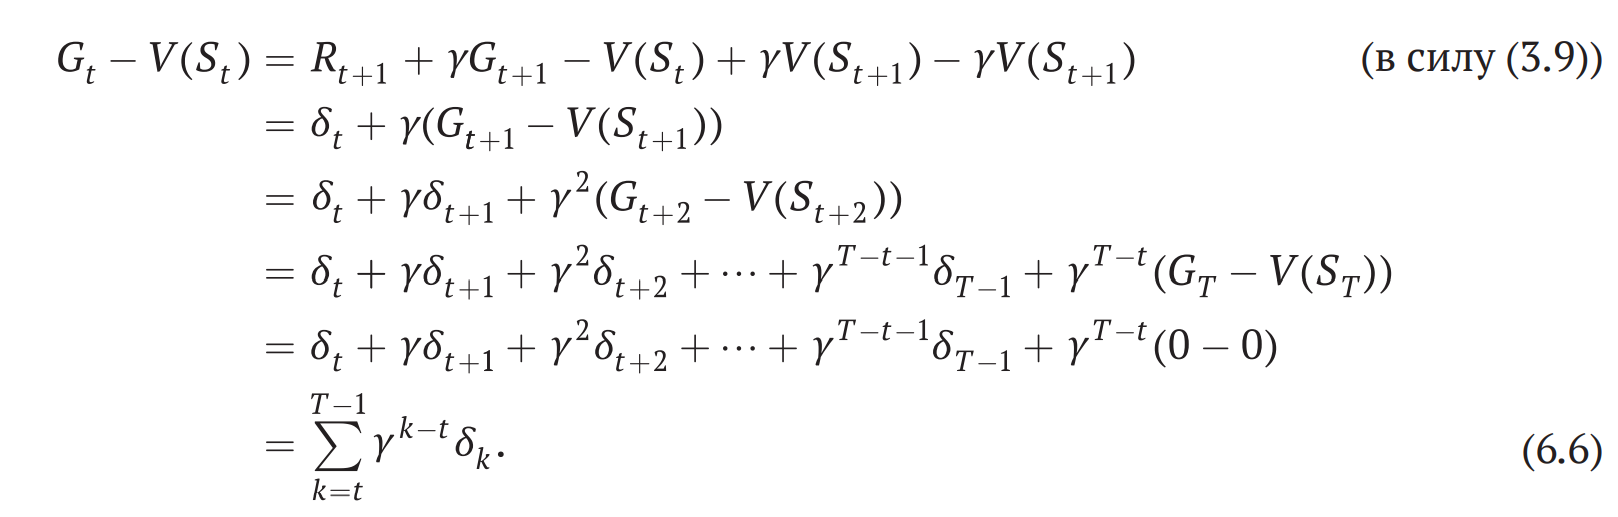

$\Rightarrow G_{t}^{\lambda}-\nu(S_{t}, \omega) = \sum\limits_{k=t}^{T-1}\gamma^{k-t}\delta_{k}$

**4**. Рассмотрим алгоритм **TD(λ)**

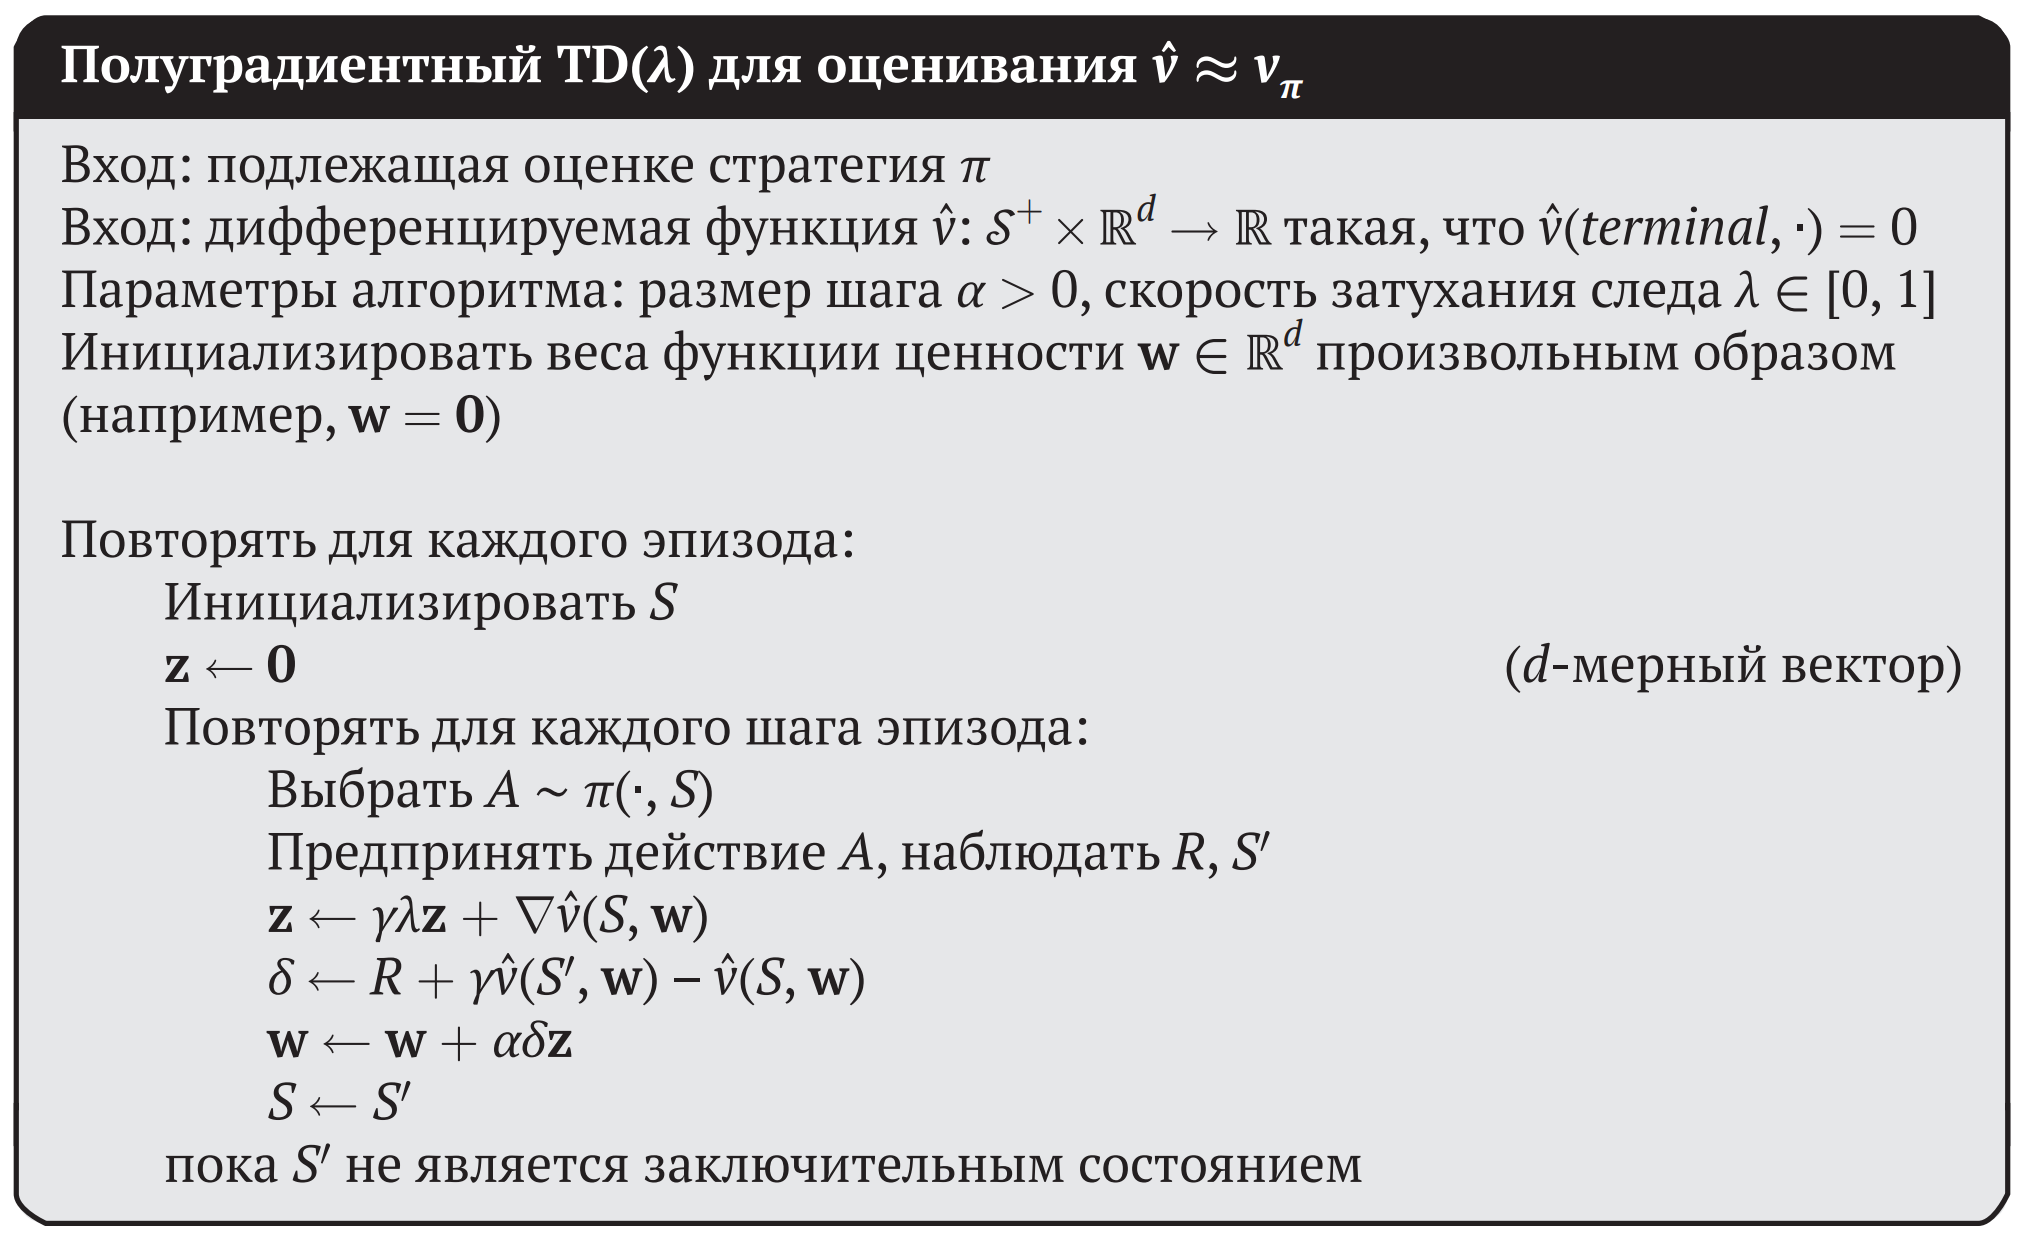

$z_{0} = 0$

$z_{1} = \nabla\nu(S_{1}, \omega)$

$z_{1} = \gamma\lambda\nabla\nu(S_{1}, \omega) + \nabla\nu(S_{2}, \omega)$

$\dots$

$z_{n} = (\gamma\lambda)^{n-1}\nabla\nu(S_{1}, \omega) + (\gamma\lambda)^{n-2}\nabla\nu(S_{2}, \omega) + \dots + \nabla\nu(S_{n}, \omega)$

$\omega = \omega_{0} + \alpha\sum\limits_{k=1}^{n}\delta_{k}z_{k}$

**5**. Рассмотрим оффлайновый алгоритм $\lambda$-отдачи

$w_{t+1} =  w_{t} + \alpha[G_{t}^{\lambda} - \nu(S_{t},\omega)]= w_{t} + \alpha\big[\sum\limits_{k=t}^{T-1}\gamma^{k-t}\delta_{k}\big]\nabla\nu(S_{t},\omega) = $

$= w_{t-1} + \alpha\big[\sum\limits_{k=t}^{T-1}\gamma^{k-t}\delta_{k}\big]\nabla\nu(S_{t},\omega) +\alpha\big[\sum\limits_{k=t-1}^{T-1}\gamma^{k-(t-1)}\delta_{k}\big]\nabla\nu(S_{t-1},\omega) = $

$= w_{0} + \alpha\big[\sum\limits_{k=1}^{T-1}\gamma^{k-1}\delta_{k}\big]\nabla\nu(S_{1},\omega) + \dots + \alpha\big[\sum\limits_{k=t}^{T-1}\gamma^{k-t}\delta_{k}\big]\nabla\nu(S_{t},\omega)$

**6**. Просуммировав по столбцам значения $\delta_{k}z_{k}$ для $\omega$ из пункта **4**, получим представление для $\omega$ из пункта **5**.



# **Задание BC.1**

Получите результаты вашей реализации в двух средах: Ant и любой
другой. В Ant качество должно быть не хуже $25\%$ от качества эксперта.

## utils

In [ ]:
def create_path(data_path, args):
  if args.do_dagger:
    logdir_prefix = 'q2_'  
    assert args.n_iter>1
  else:
    logdir_prefix = 'q1_' 
    assert args.n_iter==1

  if not (os.path.exists(data_path)):
      os.makedirs(data_path)
  logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
          '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
  logdir = os.path.join(data_path, logdir)
  args['logdir'] = logdir
  if not(os.path.exists(logdir)):
      os.makedirs(logdir)
  return args

## Ant-v2

`eval_batch_size` $= 10000$

`ep_len` $= 1000$

In [ ]:
logdir ='/content/cds_rl_2022/hw1/data/BC1' 
args = create_path(logdir, Args())

assert args['eval_batch_size'] == 10000, 'eval_batch_size != 10000'
assert args['ep_len'] == 1000, 'ep_len != 1000'

In [ ]:
print(args.logdir)
trainer = BC_Trainer(args)
trainer.run_training_loop()

### Результаты

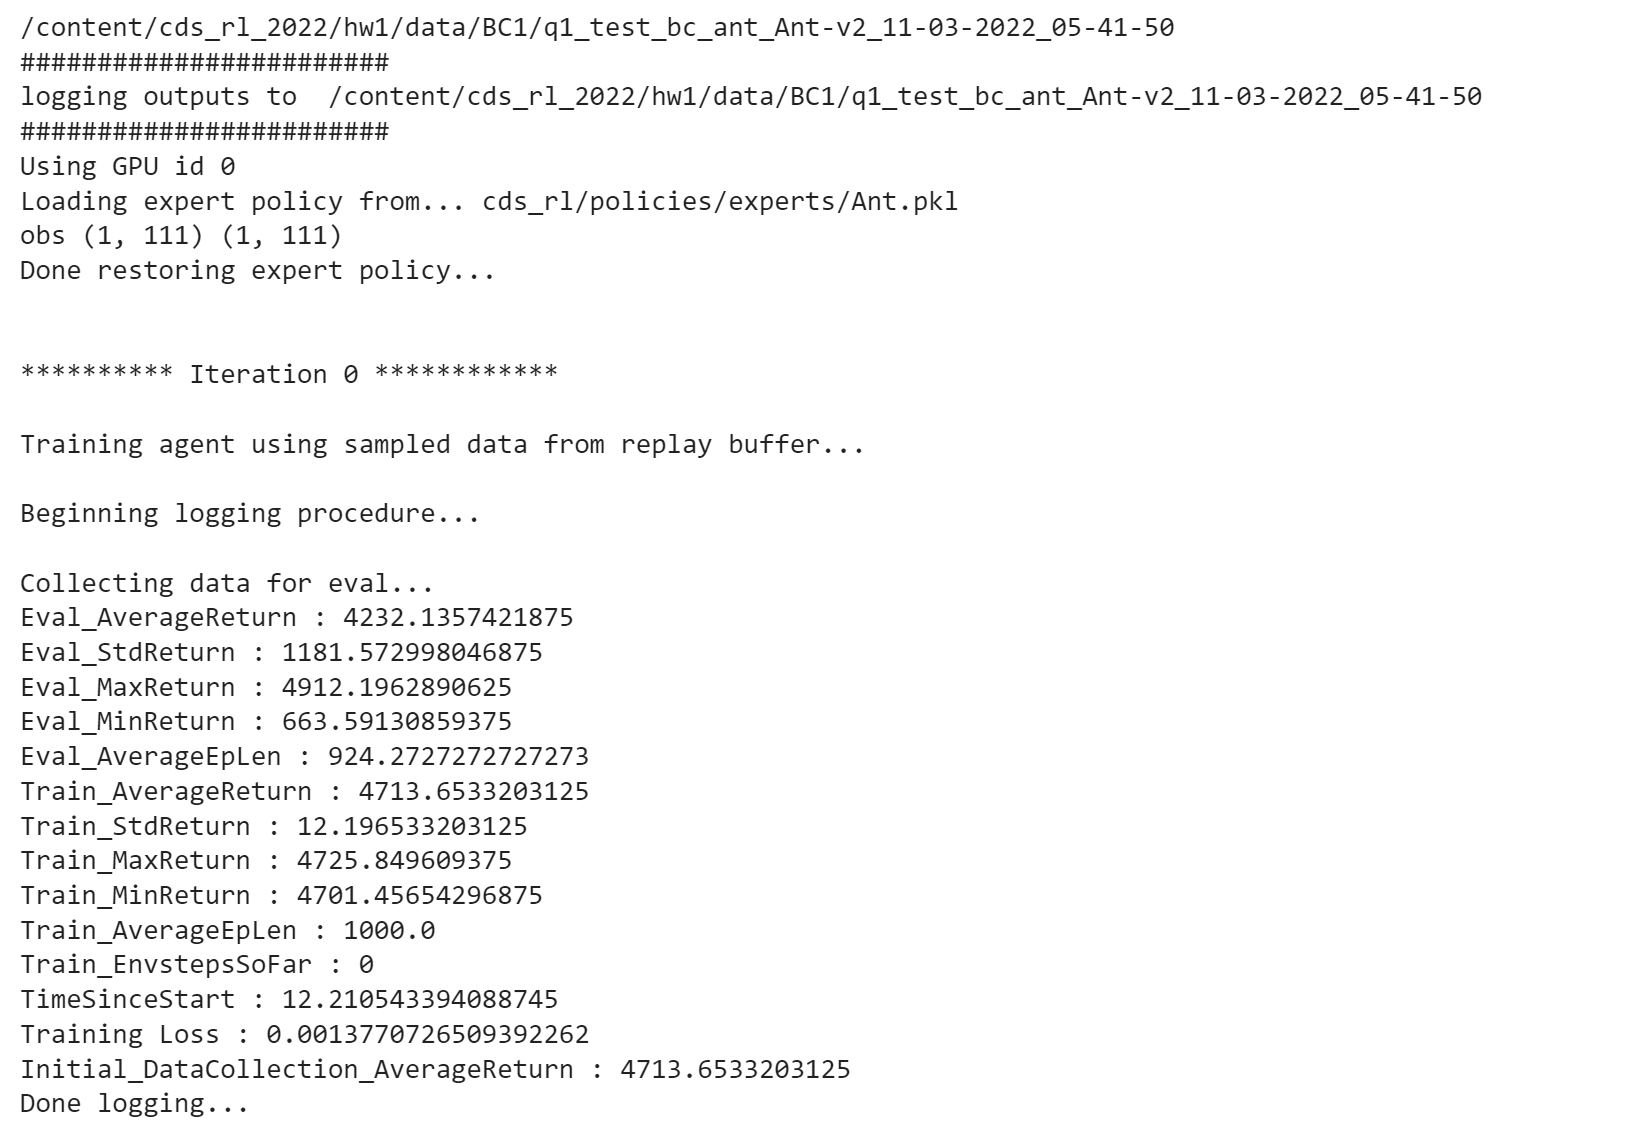

## Walker2d-v2

In [ ]:
args = Args()

args.expert_data ='cds_rl/expert_data/expert_data_Walker2d-v2.pkl'
args.expert_policy_file = 'cds_rl/policies/experts/Walker2d.pkl'
args.env_name = 'Walker2d-v2'

data_path ='/content/cds_rl_2022/hw1/data/BC1'
args = create_path(logdir, args)

In [ ]:
print(args.logdir)
trainer = BC_Trainer(args)
trainer.run_training_loop()

/content/cds_rl_2022/hw1/data/BC1/q1_test_bc_ant_Walker2d-v2_11-03-2022_14-55-50
########################
logging outputs to  /content/cds_rl_2022/hw1/data/BC1/q1_test_bc_ant_Walker2d-v2_11-03-2022_14-55-50
########################
Using GPU id 0
Loading expert policy from... cds_rl/policies/experts/Walker2d.pkl
obs (1, 17) (1, 17)
Done restoring expert policy...


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 1516.0469970703125
Eval_StdReturn : 1900.3565673828125
Eval_MaxReturn : 5280.54052734375
Eval_MinReturn : 1.1928061246871948
Eval_AverageEpLen : 326.8787878787879
Train_AverageReturn : 5566.845703125
Train_StdReturn : 9.237548828125
Train_MaxReturn : 5576.08349609375
Train_MinReturn : 5557.6083984375
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 7.548413515090942
Training Loss : 0.018163254484534264
Initial_DataCollection_AverageReturn : 5566.845703125
Done 

### Результаты

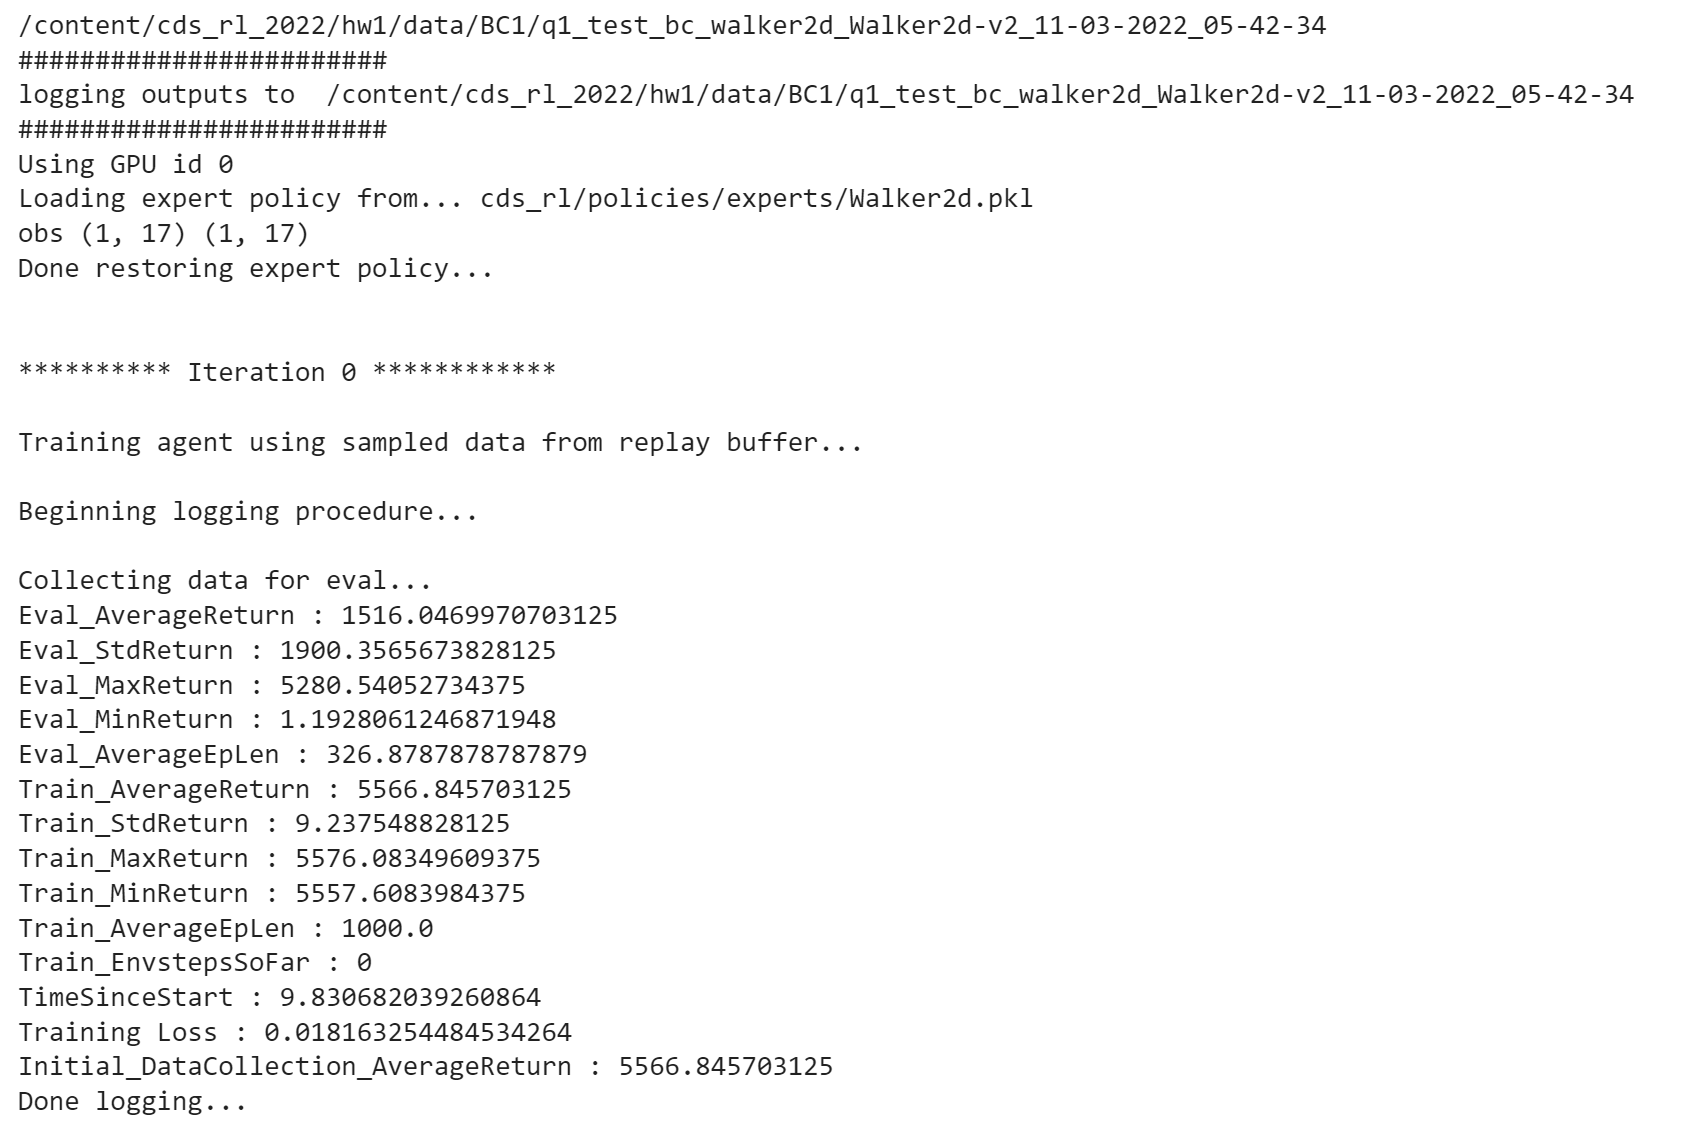

# **Задание BC.2** 

Поэкспериментируйте с разными наборами гиперпараметров (например, число шагов обучения, объем предоставленных экспертных данных и т.п.). Для одного фиксированного гиперпараметра постройте график изменения качества работы агента [на одной из сред из первого задания] и поясните ваш выбор этого параметра.

## utils

In [ ]:
def convert_tb_data(root_dir, sort_by=None):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """
    import os
    import pandas as pd
    from tensorflow.python.summary.summary_iterator import summary_iterator

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)
        
    return all_df.reset_index(drop=True)    

## network `size` optimization



In [ ]:
args = Args()

args.expert_data ='cds_rl/expert_data/expert_data_Walker2d-v2.pkl'
args.expert_policy_file = 'cds_rl/policies/experts/Walker2d.pkl'
args.env_name = 'Walker2d-v2'

logdir ='/content/cds_rl_2022/hw1/data/BC2/size'
base = create_path(logdir, args)

sizes = np.linspace(10, 500, 50)
for size in sizes:
  args = create_path(logdir, base)
  args.size = int(size)

  trainer = BC_Trainer(args)
  trainer.run_training_loop()

########################
logging outputs to  /content/cds_rl_2022/hw1/data/BC2/size/q1_test_bc_ant_Walker2d-v2_11-03-2022_15-37-31
########################
Using GPU id 0
Loading expert policy from... cds_rl/policies/experts/Walker2d.pkl
obs (1, 17) (1, 17)
Done restoring expert policy...


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 1332.330810546875
Eval_StdReturn : 718.862548828125
Eval_MaxReturn : 3412.61962890625
Eval_MinReturn : 543.6422119140625
Eval_AverageEpLen : 363.85714285714283
Train_AverageReturn : 5566.845703125
Train_StdReturn : 9.237548828125
Train_MaxReturn : 5576.08349609375
Train_MinReturn : 5557.6083984375
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 6.820920467376709
Training Loss : 0.0691516101360321
Initial_DataCollection_AverageReturn : 5566.845703125
Done logging...


########################
logging outputs to  /content/cds_rl_2022/hw

In [ ]:
files = os.listdir(logdir)
Eval_AverageReturns = []
for file in files:
  df = convert_tb_data(f"{logdir}/{file}")
  Eval_AverageReturns.append(df['value'][0])

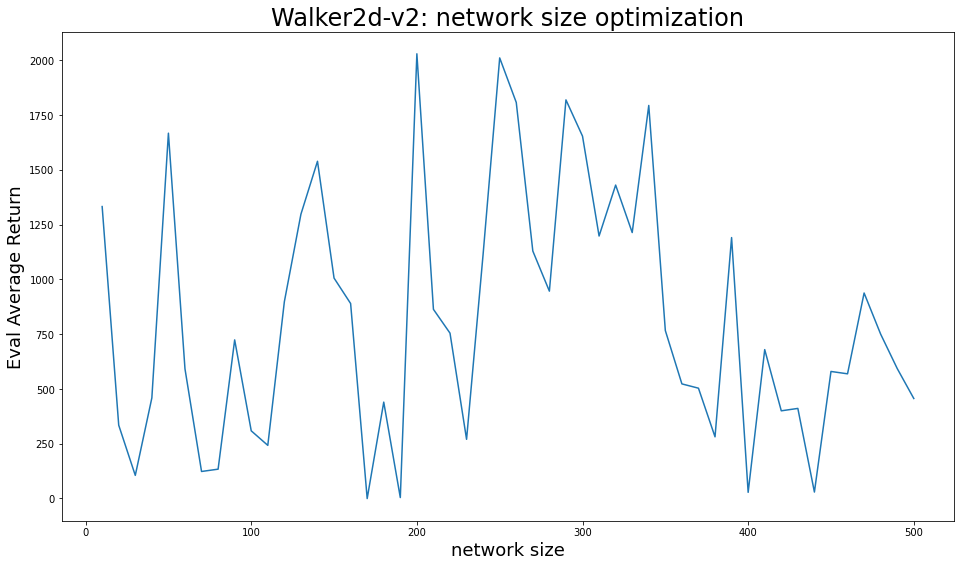

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(sizes, Eval_AverageReturns)
plt.ylabel('Eval Average Return', fontsize = 18)
plt.xlabel('network size', fontsize = 18)
plt.title('Walker2d-v2: network size optimization', fontsize = 24)
plt.show()

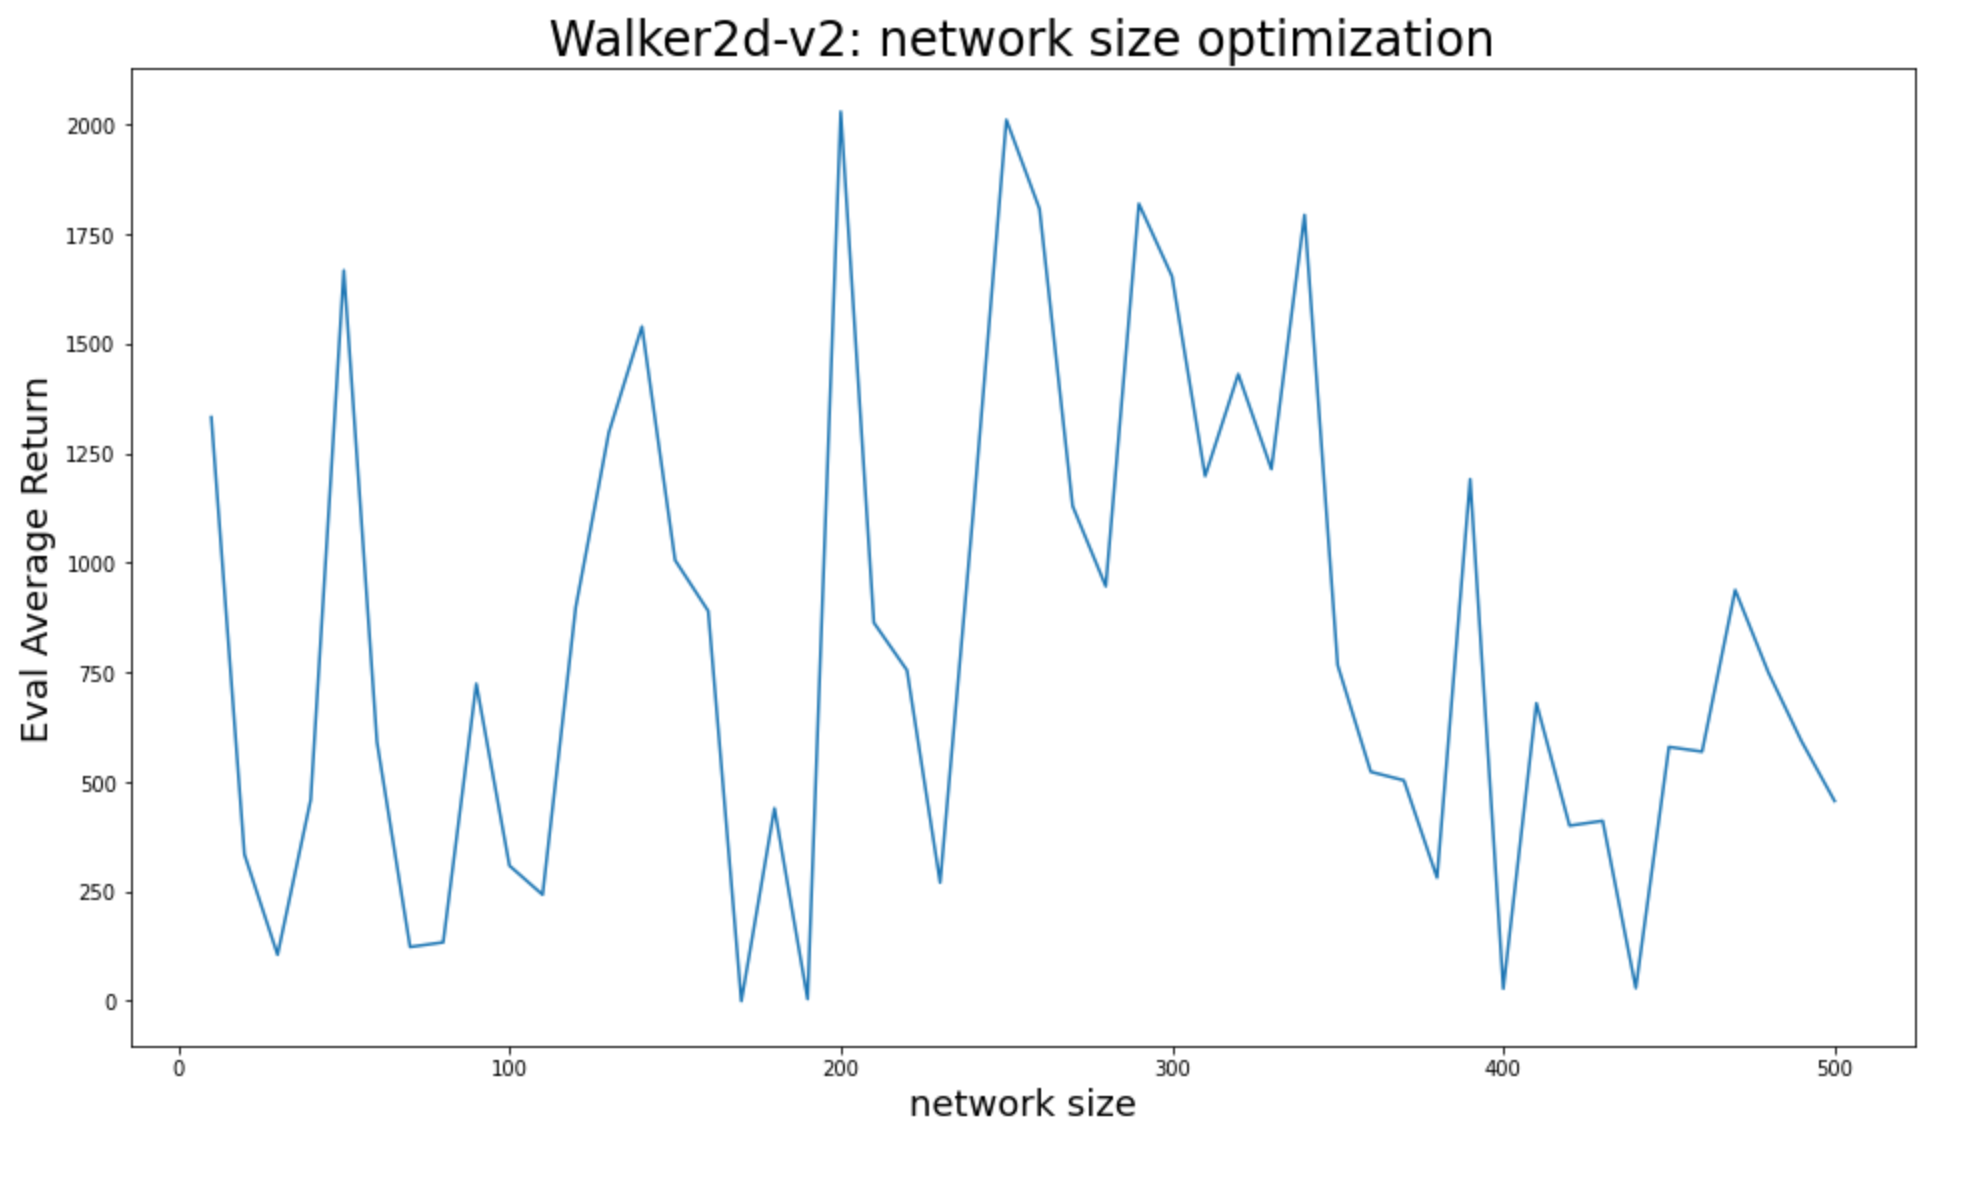

**best** ```size = 200```

## `learning_rate` optimization

In [ ]:
low_bound = 1e-3
upper_bound = 1e-2
dots = 50

learning_rates = np.linspace(low_bound, upper_bound, dots)

In [ ]:
args = Args()

args.expert_data ='cds_rl/expert_data/expert_data_Walker2d-v2.pkl'
args.expert_policy_file = 'cds_rl/policies/experts/Walker2d.pkl'
args.env_name = 'Walker2d-v2'

logdir ='/content/cds_rl_2022/hw1/data/BC2/learning_rate'
base = create_path(logdir, args)

for lr in learning_rates:
  args = create_path(logdir, base)
  args.learning_rate = lr

  trainer = BC_Trainer(args)
  trainer.run_training_loop()

########################
logging outputs to  /content/cds_rl_2022/hw1/data/BC2/learning_rate/q1_test_bc_ant_Walker2d-v2_11-03-2022_15-47-13
########################
Using GPU id 0
Loading expert policy from... cds_rl/policies/experts/Walker2d.pkl
obs (1, 17) (1, 17)
Done restoring expert policy...


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 41.07718276977539
Eval_StdReturn : 75.43538665771484
Eval_MaxReturn : 193.45823669433594
Eval_MinReturn : -0.32142698764801025
Eval_AverageEpLen : 30.162650602409638
Train_AverageReturn : 5566.845703125
Train_StdReturn : 9.237548828125
Train_MaxReturn : 5576.08349609375
Train_MinReturn : 5557.6083984375
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 6.825160503387451
Training Loss : 0.040038906037807465
Initial_DataCollection_AverageReturn : 5566.845703125
Done logging...


########################
logging outputs to  /conte

In [ ]:
files = os.listdir(logdir)
Eval_AverageReturns = []
for file in files:
  df = convert_tb_data(f"{logdir}/{file}")
  Eval_AverageReturns.append(df['value'][0])

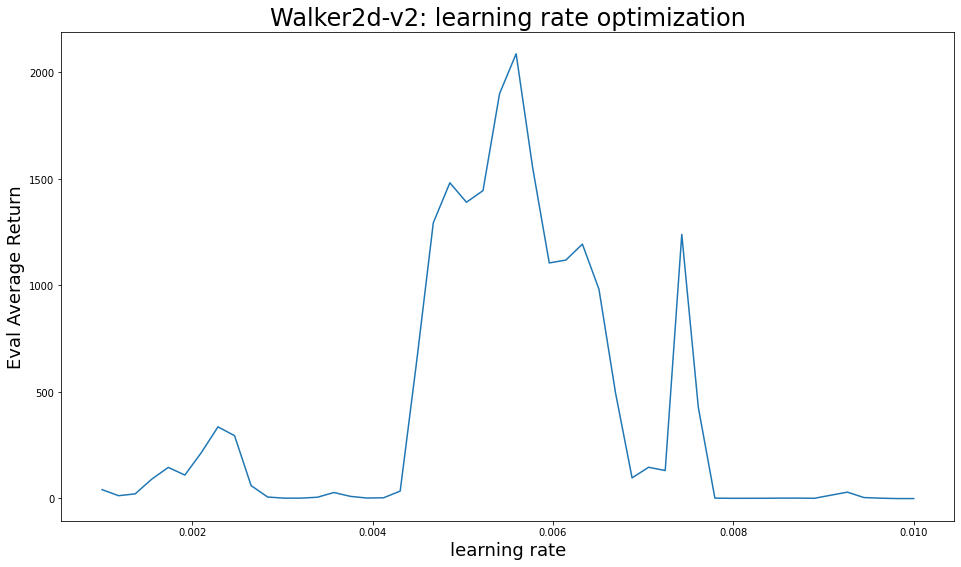

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(learning_rates, Eval_AverageReturns)
plt.ylabel('Eval Average Return', fontsize = 18)
plt.xlabel('learning rate', fontsize = 18)
plt.title('Walker2d-v2: learning rate optimization', fontsize = 24)
plt.show()

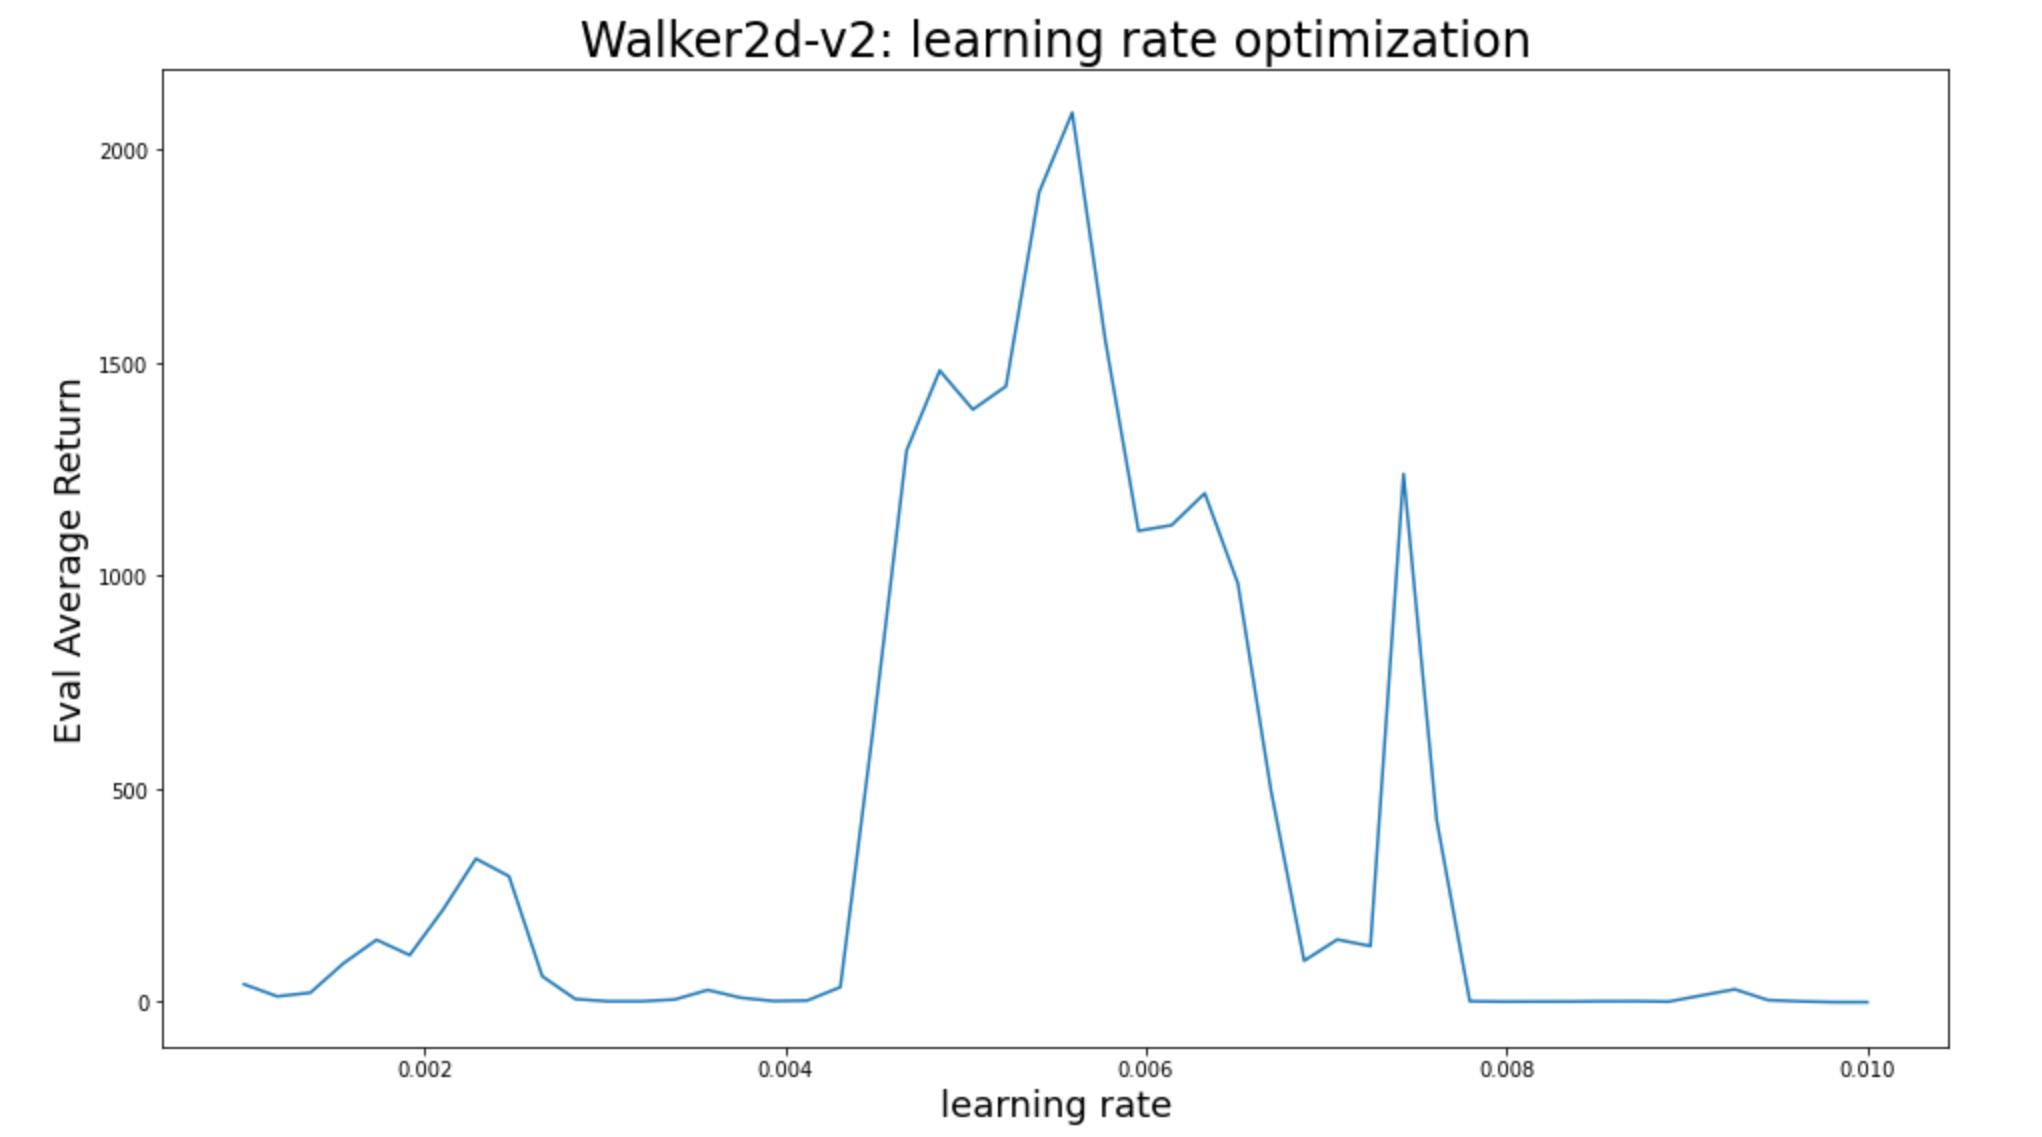

**best** ```learning rate = 0.005591836734693878```



In [ ]:
#@markdown You can visualize your runs with tensorboard from within the notebook

%load_ext tensorboard
%tensorboard --logdir /content/cds_rl_2022/hw1/data

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 3583.

# **Running DAgger (Problem 2)**
Modify the settings above:
1. check the `do_dagger` box
2. set `n_iters` to `10`
and then rerun the code.

In [ ]:
args = Args()

args.expert_data ='cds_rl/expert_data/expert_data_Walker2d-v2.pkl'
args.expert_policy_file = 'cds_rl/policies/experts/Walker2d.pkl'
args.env_name = 'Walker2d-v2'

# hyperparameters
args.do_dagger = True
args.n_iter = 10 
args.size = 200
args.learning_rate = 0.0056

logdir ='/content/cds_rl_2022/hw1/data/BC3'
args = create_path(logdir, args)

In [ ]:
# run training
print(args.logdir)
trainer = BC_Trainer(args)
trainer.run_training_loop()

/content/cds_rl_2022/hw1/data/BC3/q2_test_bc_ant_Walker2d-v2_11-03-2022_16-25-21
########################
logging outputs to  /content/cds_rl_2022/hw1/data/BC3/q2_test_bc_ant_Walker2d-v2_11-03-2022_16-25-21
########################
Using GPU id 0
Loading expert policy from... cds_rl/policies/experts/Walker2d.pkl
obs (1, 17) (1, 17)
Done restoring expert policy...


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 2173.73974609375
Eval_StdReturn : 1532.301513671875
Eval_MaxReturn : 4589.4765625
Eval_MinReturn : 572.162841796875
Eval_AverageEpLen : 539.4736842105264
Train_AverageReturn : 5566.845703125
Train_StdReturn : 9.237548828125
Train_MaxReturn : 5576.08349609375
Train_MinReturn : 5557.6083984375
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 9.58299469947815
Training Loss : 0.009148462675511837
Initial_DataCollection_AverageReturn : 5566.845703125
Done logging...

100%|██████████| 41/41 [00:02<00:00, 18.72it/s]


Eval_AverageReturn : 5499.6083984375
Eval_StdReturn : 42.37540817260742
Eval_MaxReturn : 5569.84716796875
Eval_MinReturn : 5422.54736328125
Eval_AverageEpLen : 1000.0
Train_AverageReturn : 5156.7197265625
Train_StdReturn : 0.0
Train_MaxReturn : 5156.7197265625
Train_MinReturn : 5156.7197265625
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 5901
TimeSinceStart : 54.162227153778076
Training Loss : 0.00898270308971405
Initial_DataCollection_AverageReturn : 5566.845703125
Done logging...




********** Iteration 6 ************


Relabelling collected observations with labels from an expert policy...

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 5421.4912109375
Eval_StdReturn : 53.55064010620117
Eval_MaxReturn : 5500.7587890625
Eval_MinReturn : 5289.7880859375
Eval_AverageEpLen : 1000.0
Train_AverageReturn : 5439.814453125
Train_StdReturn : 0.0
Train_MaxReturn : 5439.814453125
Train_MinReturn : 5439.814453125
Train_AverageE

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/cds_rl_2022/hw1/data/BC3

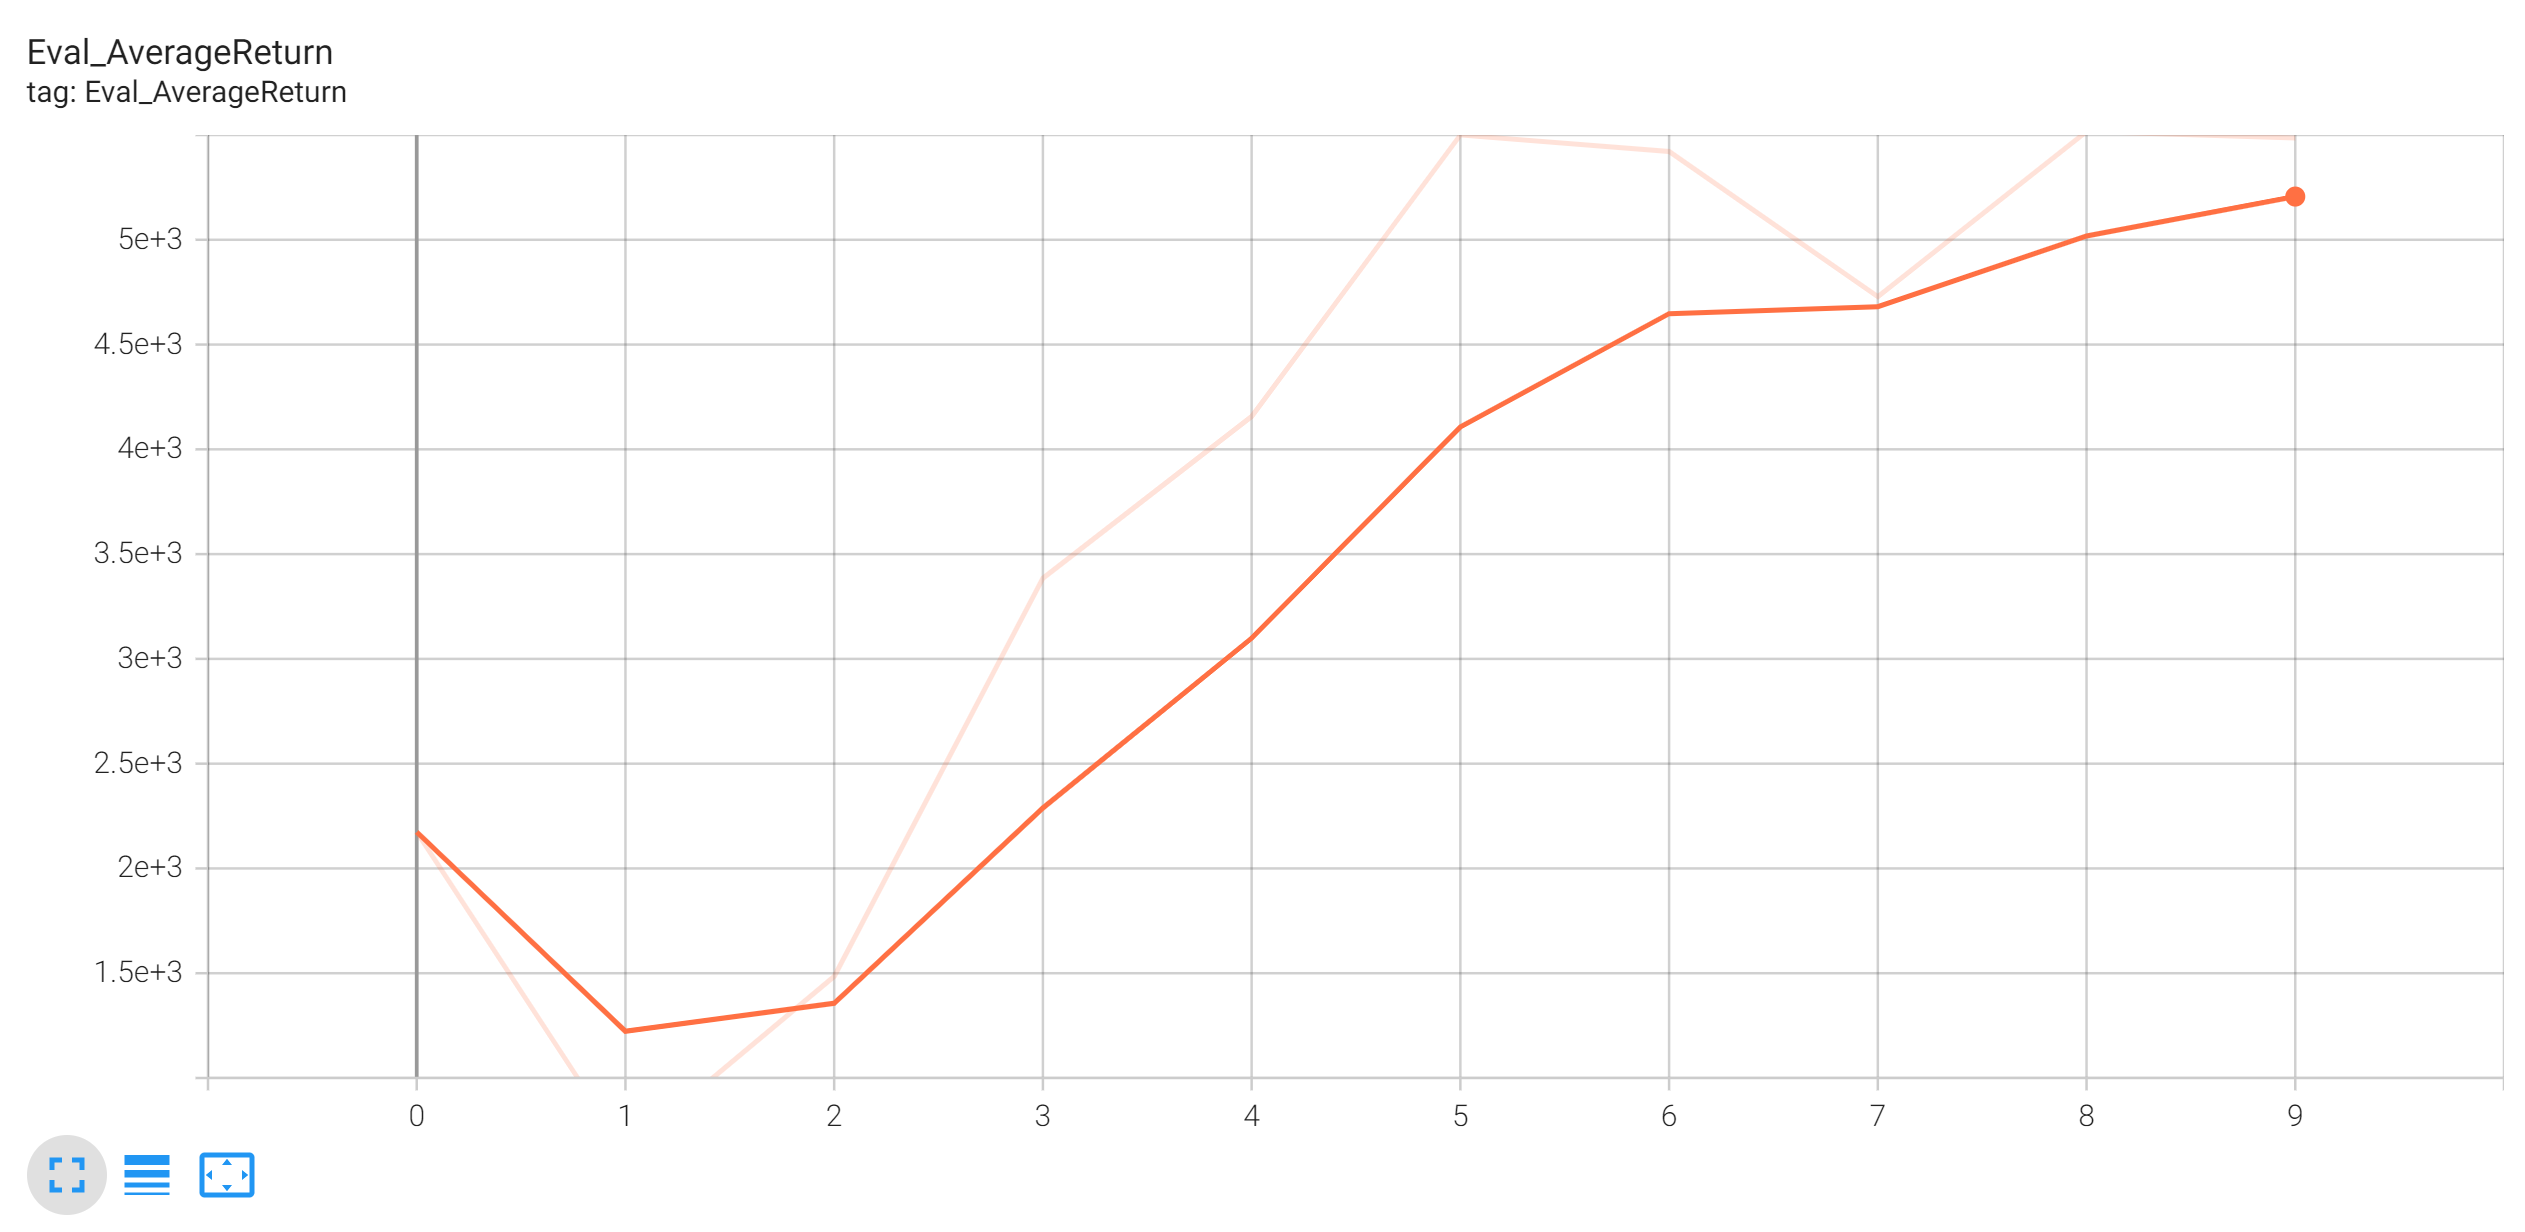

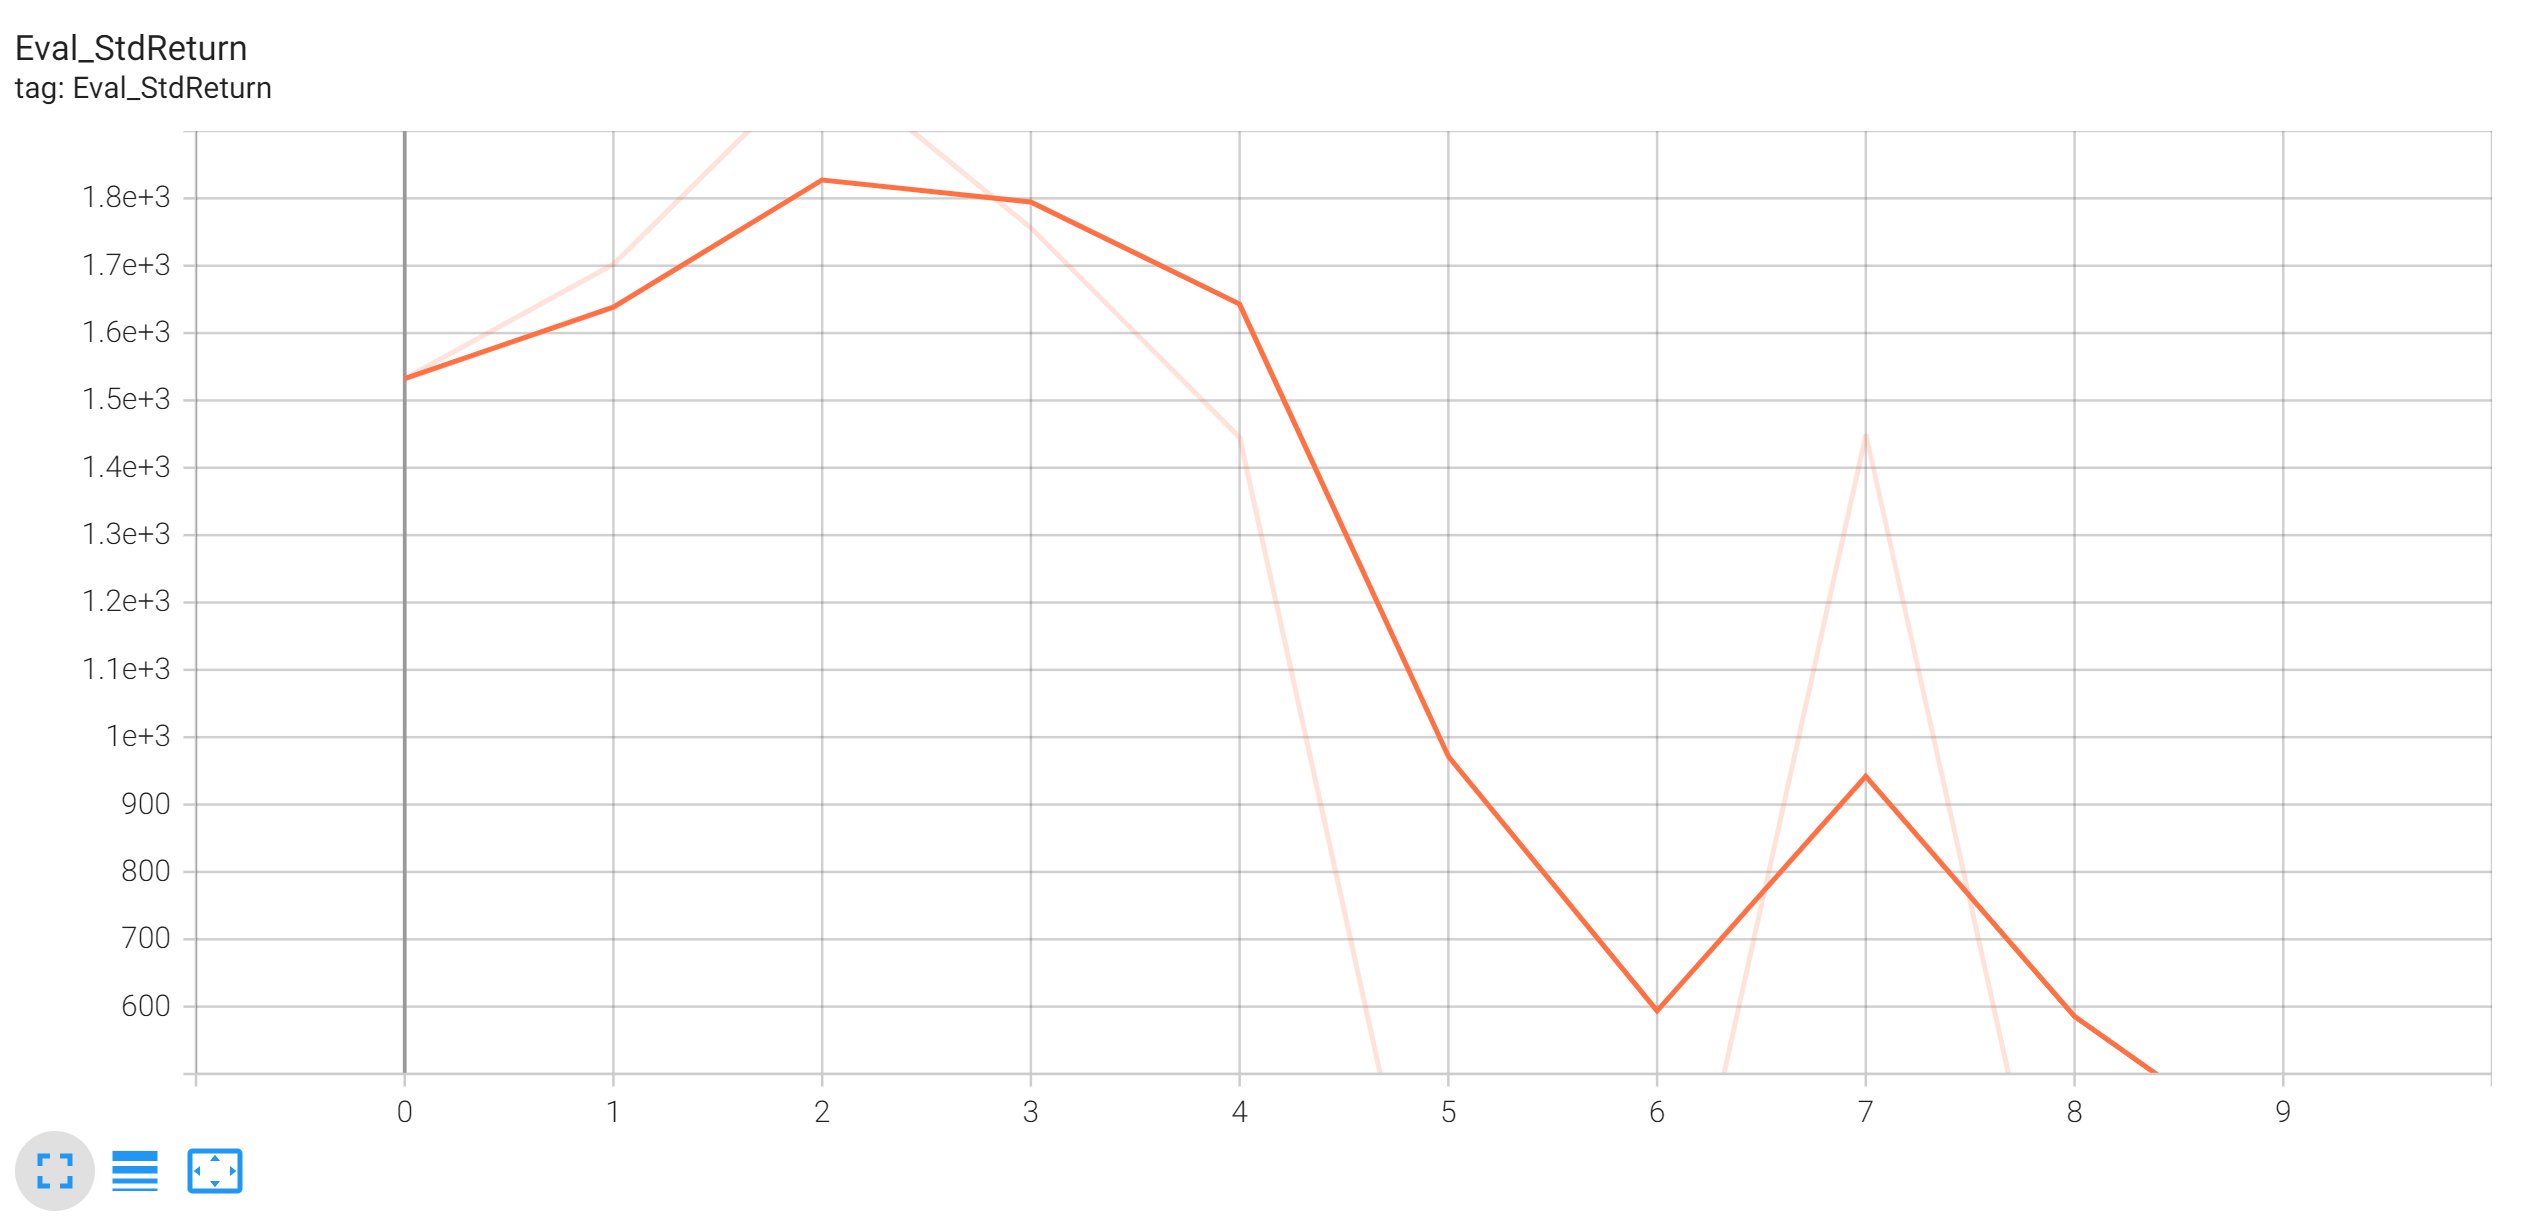

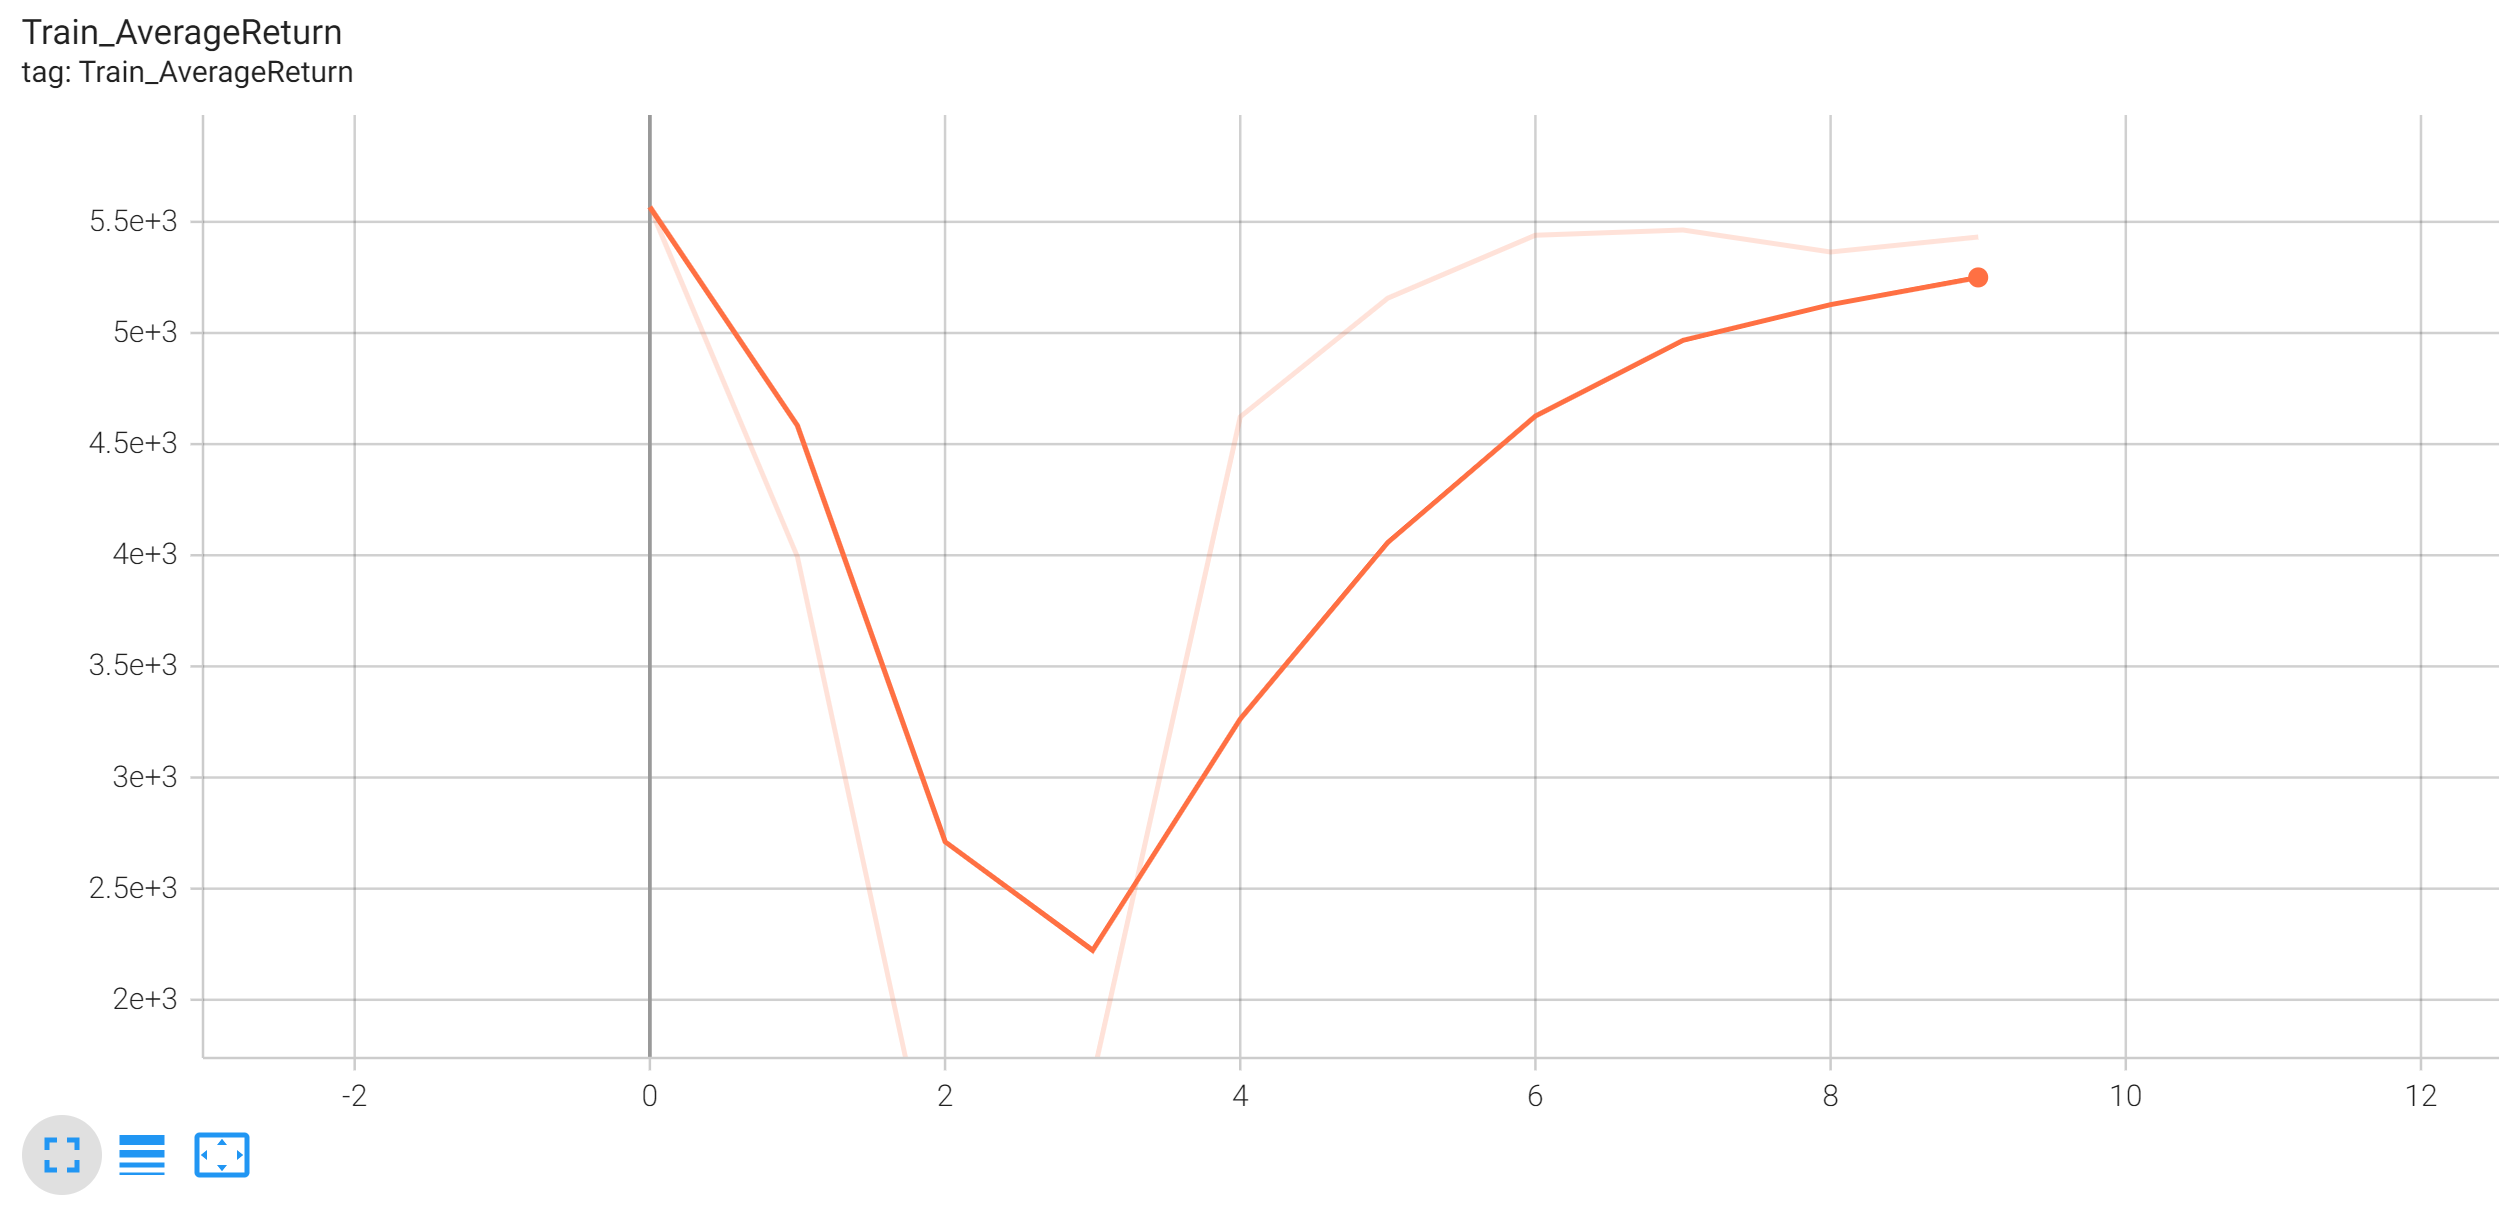

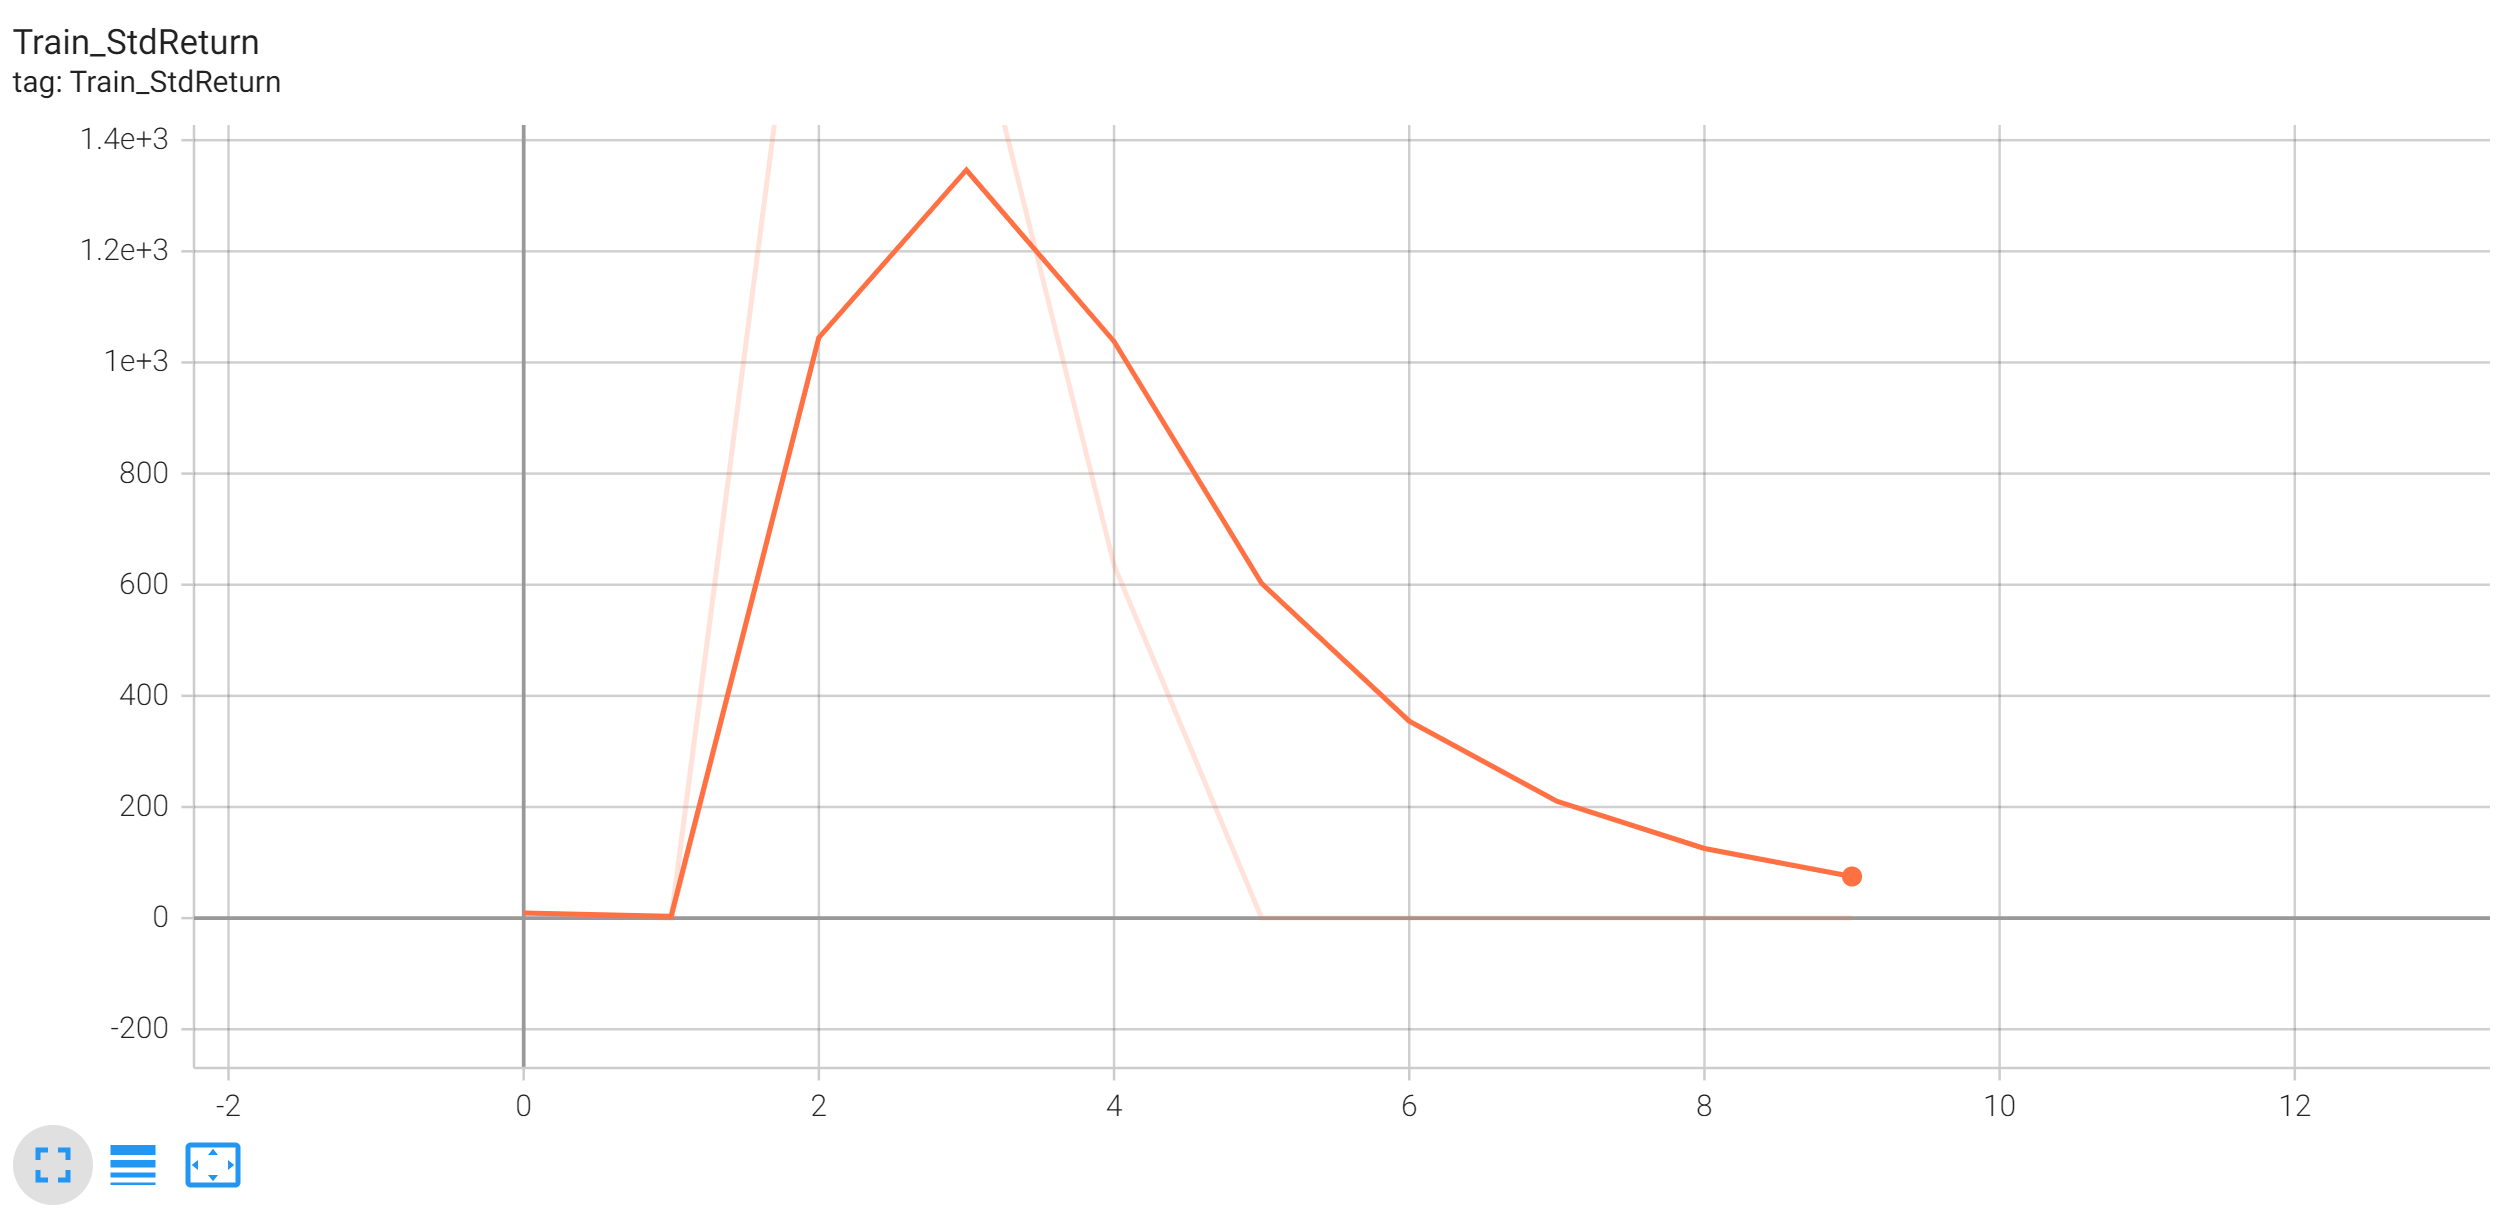